In [1]:
import model as Model
import pandas as pd
import os

import importlib


import numpy as np
import matplotlib.pyplot as plt
import cv2
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [2]:
importlib.reload(Model)

<module 'model' from 'c:\\home\\WUT\\Semester_1\\IML\\human-age-detection\\train\\models\\regression\\model.py'>

In [5]:
path_to_metadatacsv = os.path.realpath('D:\WUT\IML/data/metadata-clean.csv')
metadata = pd.read_csv(path_to_metadatacsv)

In [6]:
metadata['target'] = metadata['age'].map(Model.class_labels_reassign)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(metadata['path'], metadata['target'],
                                                    test_size=0.33, random_state=42)


train_filenames_list = list(X_train)
train_labels_list = list(y_train)

test_filenames_list = list(X_test)
test_labels_list = list(y_test)

# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.
train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)
test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [6]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(Model._parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(Model._parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512) 

In [7]:
# Defining the architecture of the sequential neural network.
final_cnn = Sequential()
# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())
# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))
# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))
final_cnn.summary()

# Compiling the above created CNN architecture.
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creating a TensorBoard callback object and saving it at the desired location.
tensorboard = TensorBoard(log_dir=f"D:\WUT\IML/output/cnn_logs")
      


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 128)       

In [8]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"D:\WUT\IML/output/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )
                            
# Fitting the above created CNN model.
final_cnn_history = final_cnn.fit(train_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=2,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/2


294/294 [==============================] - ETA: 0s - loss: 1.3965 - accuracy: 0.4946 
Epoch 1: val_accuracy improved from -inf to 0.49832, saving model to D:\WUT\IML/output/cnn_logs\age_model_checkpoint.h5


c:\ProgramFiles\Anaconda3\envs\tensorflow\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


294/294 [==============================] - 4103s 14s/step - loss: 1.3965 - accuracy: 0.4946 - val_loss: 1.3386 - val_accuracy: 0.4983
Epoch 2/2
294/294 [==============================] - ETA: 0s - loss: 1.3106 - accuracy: 0.4997 
Epoch 2: val_accuracy improved from 0.49832 to 0.49858, saving model to D:\WUT\IML/output/cnn_logs\age_model_checkpoint.h5
294/294 [==============================] - 4005s 14s/step - loss: 1.3106 - accuracy: 0.4997 - val_loss: 1.3193 - val_accuracy: 0.4986


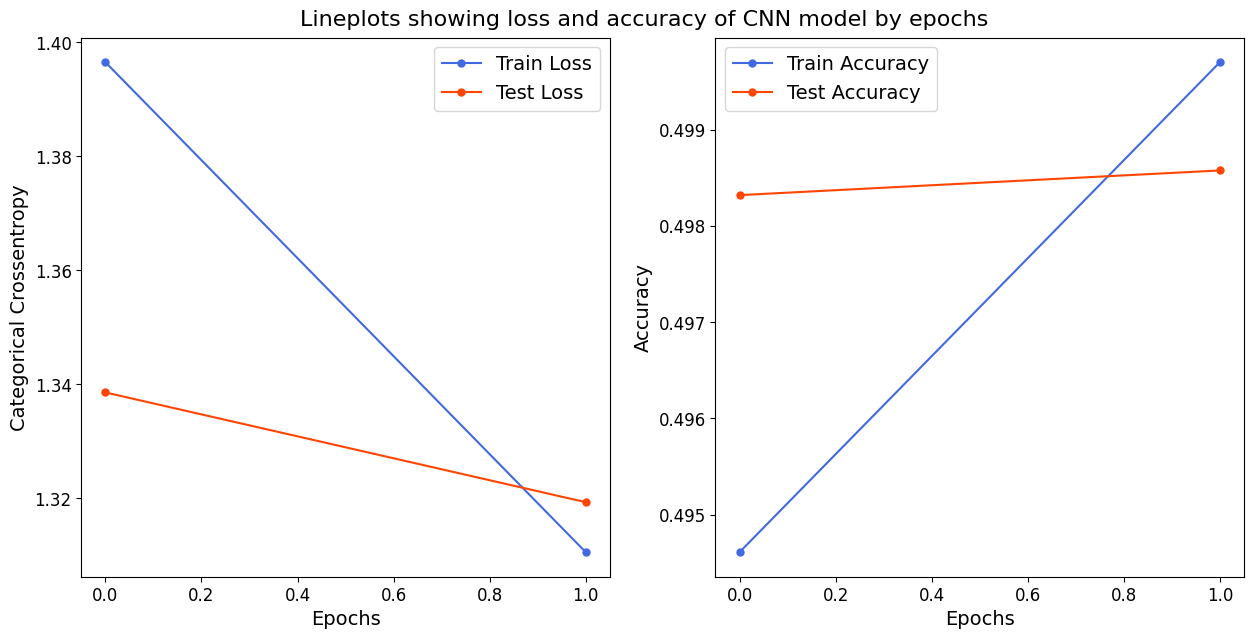

In [9]:
# Checking the train and test loss and accuracy values from the neural network above.
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('D:\WUT\IML/output/cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight');

145/145 [==============================] - 402s 3s/step - loss: 1.3193 - accuracy: 0.4986
CNN model loss 		= 1.319
CNN model accuracy 	= 0.499


c:\ProgramFiles\Anaconda3\envs\tensorflow\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


145/145 [==============================] - 418s 3s/step
Normalized confusion matrix


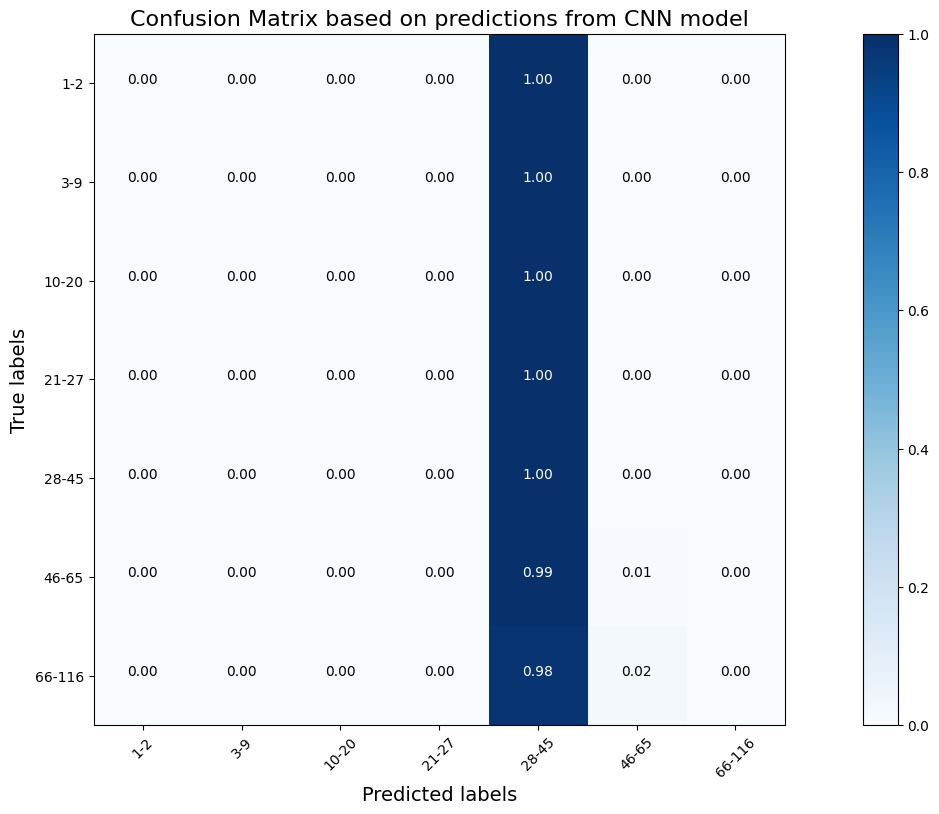

In [11]:
# Evaluating the model on test dataset.
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)
# Printing the relevant score summary.
final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

# Saving the model as a h5 file for possible use later.
final_cnn.save(f"D:\WUT\IML/output/age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')

# Generating predictions from the model above.
final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)
# Generating a confusion matrix based on above predictions.
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)

# Defining a function to plot the confusion matrix in a grid for easier visualization.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    # Exporting plot image in PNG format.
    plt.savefig(f'D:\WUT\IML/output/cnn_logs/{export_as}.png', bbox_inches='tight');

# Plotting the confusion matrix using the function defined above.
cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()

In [33]:
path = list([metadata.iloc[0]['path'], metadata.iloc[1]['path']])
label = list([metadata.iloc[0]['target'], metadata.iloc[1]['target']])

check_filenames_tensor = tf.constant(path)
check_labels_tensor = tf.constant(label)

check_dataset = tf.data.Dataset.from_tensor_slices((check_filenames_tensor, check_labels_tensor))
check_dataset = check_dataset.map(Model._parse_function)
# test_dataset = test_dataset.repeat(3)
check_dataset = check_dataset.batch(512) 

pred = final_cnn.predict(check_dataset)
pred = final_cnn_pred.argmax(axis=-1)
pred

1/1 [==============================] - 0s 59ms/step


105

In [17]:
saved_model = tf.keras.models.load_model('D:\WUT\IML/output/age_model_acc_0.499.h5')

In [18]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 128)       0

In [40]:
path = list([metadata.iloc[24]['path']])
label = list([metadata.iloc[24]['target']])

check_filenames_tensor = tf.constant(path)

check_dataset = tf.data.Dataset.from_tensor_slices((check_filenames_tensor, tf.constant(list([-1]))))
check_dataset = check_dataset.map(Model._parse_function)
# test_dataset = test_dataset.repeat(3)
check_dataset = check_dataset.batch(1) 

pred = saved_model.predict(check_dataset)
pred = np.argmax(pred, axis=-1)
print(f"Actual: {label}. Prediction: {pred}")

1/1 [==============================] - 0s 69ms/step
Actual: [4]. Prediction: [4]


In [20]:
type(saved_model)

keras.src.engine.sequential.Sequential